## The door-perceptron with Gaussian (or Gauss-Bernoulli) weights

In [159]:
%matplotlib inline
from math import exp, sqrt, erf, erfc, pi, sinh
from scipy.integrate import quad
import numpy as np
import matplotlib.pyplot as plt

#Routines
def Stability(rho, K=1):
    A = 4 * K * K * exp(- K * K / rho) / (2 * pi * rho)
    B = (1. / erf(K / sqrt(2 * rho)) + 1. / erfc(K / sqrt(2 * rho)))
    return A * B

def Gauss(x):
    return exp(-x * x / 2) / sqrt(2 * pi)

def new_mx(mhat, alpha, rhoX, f_x):
    def f_to_int(x):
        return Gauss(x) * (f_x(1. / (alpha*mhat),0 + x / sqrt((alpha * mhat)) , rhoX)) ** 2
    (int1,err1) = quad(f_to_int, -10, 10)
    
    int2=0
    if (rhoX>0.001):
        def g_to_int(x):
            return Gauss(x) * (f_x(1. / (alpha*mhat),x*sqrt(1+1./(alpha*mhat)),rhoX))**2
        (int2,err2)=quad(g_to_int,-10,10)

    return (1-rhoX)*int1+(rhoX)*int2;

def gout(w,Y,V,theta=1):
    V=V+1e-6;
    A=((2*Y)/(sqrt(2*pi*V)));
    B=exp(-(theta**2+w**2)/(2*V)-theta*w/V)*(exp(2*theta*w/V)-1);
    if (w>0):
        B=exp(-(theta**2+w**2)/(2*V)+theta*w/V)*(1-exp(-2*theta*w/V));

    bb1=exp(-(theta**2+w**2)/(2*V));
    bb2=sinh(theta*w/V);    
    C=1E-5+erfc(-Y*(theta+w)/(sqrt(2*V)))-Y*erfc((theta-w)/(sqrt(2*V)));
    return A*B/C;

def new_mhat(mx,Z02,theta=1):
    V_eff=max(Z02-mx,1e-5);
    mx=mx+1e-5;

    def g(x):
        return (gout(x*sqrt(mx),1,V_eff,theta)**2)*(1-0.5*erfc((theta+x*sqrt(mx))/sqrt(2*V_eff))-0.5*erfc((theta-x*sqrt(mx))/sqrt(2*V_eff))) + (gout(x*sqrt(mx),-1,V_eff,theta)**2)*(0.5*erfc((theta+x*sqrt(mx))/sqrt(2*V_eff))+0.5*erfc((theta-x*sqrt(mx))/sqrt(2*V_eff)));
    def f(x):
        return Gauss(x)*g(x);

    (int1,err1)=quad(f,-5,5);
    return (int1)

def f_gaussbernoulli(S2,R,rho=1./2,m=0,s2=1):

    Z=(1-rho)*exp(-R*R/(2*S2))+rho*sqrt(S2/(S2+s2))*exp(-((R-m)**2)/(2*(S2+s2)));    
    UP2=rho*(1-rho)*exp(-R*R/(2*S2) -((R-m)**2)/(2*(S2+s2)))*(sqrt(S2)/(S2+s2)**(2.5))*(s2*S2*(S2+s2)+(m*S2+R*s2)**2)+rho*rho*exp(-((R-m)**2)/((S2+s2)))*(s2*S2**2)/(s2+S2)**2;
    UP1=rho*exp(-((R-m)**2)/(2*(S2+s2)))*(sqrt(S2)/(S2+s2)**(1.5))*(m*S2+R*s2);
    F_a=UP1/Z;
    F_b=UP2/Z**2;
    
    return F_a,F_b

In [160]:
#main loops

def perform_DE(mxstart,rhoX,alpha,f_x,theta=0,criterion=1e-6,tmax=1000):
    #First compute Z02 and init values
    Z02=rhoX
    mx=mxstart-1e-6
    diff=1
    t=0
    mhat=0;
    
#    print("t  mx      hat        MSEX   alpha");
    while ((diff>criterion and t<tmax)):
        mhat=new_mhat(mx,Z02,theta)
#        print(t,mx,mhat,Z02-mx,alpha)
        t=t+1
        mx_new=0.5*new_mx(mhat,alpha,rhoX,f_x)+0.5*mx
        diff=abs(mx_new-mx)
        mx=mx_new
        if (abs(Z02-mx)<criterion):
            break;
    return Z02-mx,mx,t;

def compute_MSE_range_alpha(rhoX,rangealpha,f_x,theta=0):
    valMSEX=np.zeros(rangealpha.size)
    valM=np.zeros(rangealpha.size)
    valt=np.zeros(rangealpha.size)

    mxstart=0.01

    print("alpha,M,t")
    for j in np.arange(1,rangealpha.size,1):
        (MSEX,M,t)=perform_DE(mxstart,rhoX,rangealpha[j],f_x,theta);
        valMSEX[j]=MSEX;
        valM[j]=M;
        valt[j]=t;
        mxstart=M;
        print(rangealpha[j],M,t)
    return valMSEX,valM,valt

In [174]:
theta=0.674489;
rhoX=1;
alpha_C=1./STABILITY(rhoX,theta)
print(alpha_C)

1.3604609538515025


In [175]:
def f_x(x,y,z):
    return f_gaussbernoulli(x,y,z,0,1)[0]

rangealpha = np.arange(0.01,2,0.01)
(X1,M1,T1)=compute_MSE_range_alpha(rhoX,rangealpha,f_x,theta)

alpha,M,t
0.02 8.978064432630656e-07 14
0.03 5.8026270313222414e-08 1
0.04 -3.378342113402721e-07 1
0.05 -5.097502152733535e-07 1
0.060000000000000005 -5.67665587890424e-07 1
0.06999999999999999 -4.079024429442603e-08 2
0.08 -2.569950820362711e-07 1
0.09 -3.393234661024915e-07 1
0.09999999999999999 -3.5138278351137285e-07 1
0.11 2.2803132522482332e-07 2
0.12 2.097060449237271e-08 1
0.13 -5.8539160590531694e-08 1
0.14 -6.92328702435005e-08 1
0.15000000000000002 5.277611218459847e-07 2
0.16 3.241110367801131e-07 1
0.17 2.445773765604986e-07 1
0.18000000000000002 2.3381536887031703e-07 1
0.19 8.473458303812619e-07 2
0.2 6.474501706970522e-07 1
0.21000000000000002 5.682642818818629e-07 1
0.22 5.577233846673333e-07 1
0.23 1.1882019217782789e-06 2
0.24000000000000002 9.926967500791223e-07 1
0.25 9.144236543257063e-07 1
0.26 9.045310983094325e-07 1
0.27 1.5525436829170214e-06 2
0.28 1.362123805177391e-06 1
0.29000000000000004 1.2854003435597927e-06 1
0.3 1.276660457348543e-06 1
0.31 1.9429289

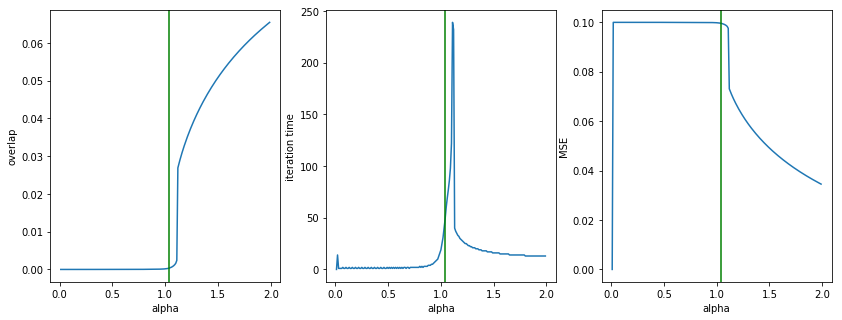

In [171]:
plt.rcParams['figure.figsize'] = [14, 5]

plt.subplot(1,3,1)
plt.plot(rangealpha,M1)
plt.ylabel('overlap')
plt.xlabel('alpha')
plt.axvline(x=alpha_C, color='g')

plt.subplot(1,3,2)
plt.plot(rangealpha,T1)
plt.axvline(x=alpha_C, color='g')
plt.ylabel('iteration time')
plt.xlabel('alpha')

plt.subplot(1,3,3)
plt.plot(rangealpha,X1)
plt.axvline(x=alpha_C, color='g')

plt.ylabel('MSE')
plt.xlabel('alpha')

plt.show()

In [172]:
rangealpha2 = np.arange(2,0.01,-0.01)
(X2,M2,T2)=compute_MSE_range_alpha(rhoX,rangealpha2,f_x,theta)

alpha,M,t
1.99 0.06546174978461068 29
1.98 0.06523874082745226 13
1.97 0.06501043469565743 13
1.96 0.06477993705485752 13
1.95 0.06454723128844696 13
1.94 0.06431227828846911 13
1.93 0.06407503767282466 13
1.92 0.0638354678907489 13
1.91 0.06359352618118591 13
1.9 0.06334916852821126 13
1.89 0.06310234961438421 13
1.88 0.06285302277191279 13
1.8699999999999999 0.06260113993150304 13
1.8599999999999999 0.062346651568750036 13
1.8499999999999999 0.06208950664792207 13
1.8399999999999999 0.061829652562974874 13
1.8299999999999998 0.06156703507562124 13
1.8199999999999998 0.06130159825027226 13
1.8099999999999998 0.06103328438564327 13
1.7999999999999998 0.06076203394281048 13
1.7899999999999998 0.060487785469482094 13
1.7799999999999998 0.06020978226056788 14
1.7699999999999998 0.05992932560418282 14
1.7599999999999998 0.05964567716673698 14
1.7499999999999998 0.059358763238714425 14
1.7399999999999998 0.05906851143875984 14
1.7299999999999998 0.058774846939171524 14
1.7199999999999998 0.

0.04999999999999827 -4.974289203486527e-07 1
0.03999999999999826 -5.853334878183498e-07 1
0.02999999999999825 -6.713972128652145e-07 1
0.01999999999999824 -7.556787159563335e-07 1


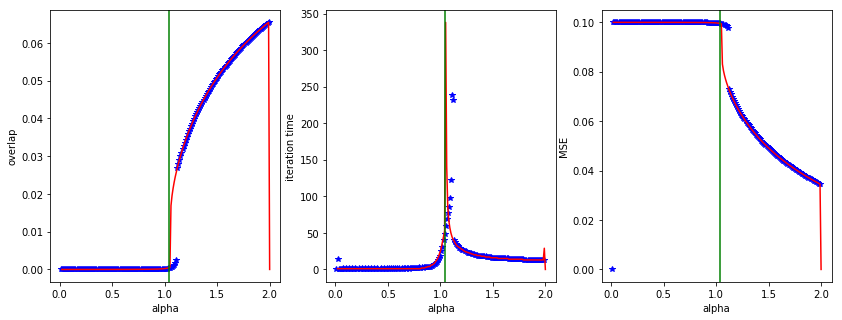

In [173]:
plt.subplot(1,3,1)
plt.plot(rangealpha,M1,'b*')
plt.plot(rangealpha2,M2,'r-')
plt.axvline(x=alpha_C, color='g')

plt.ylabel('overlap')
plt.xlabel('alpha')

plt.subplot(1,3,2)
plt.plot(rangealpha,T1,'b*')
plt.plot(rangealpha2,T2,'r-')
plt.axvline(x=alpha_C, color='g')


plt.ylabel('iteration time')
plt.xlabel('alpha')

plt.subplot(1,3,3)
plt.plot(rangealpha,X1,'b*')
plt.plot(rangealpha2,X2,'r-')
plt.axvline(x=alpha_C, color='g')


plt.ylabel('MSE')
plt.xlabel('alpha')

plt.show()